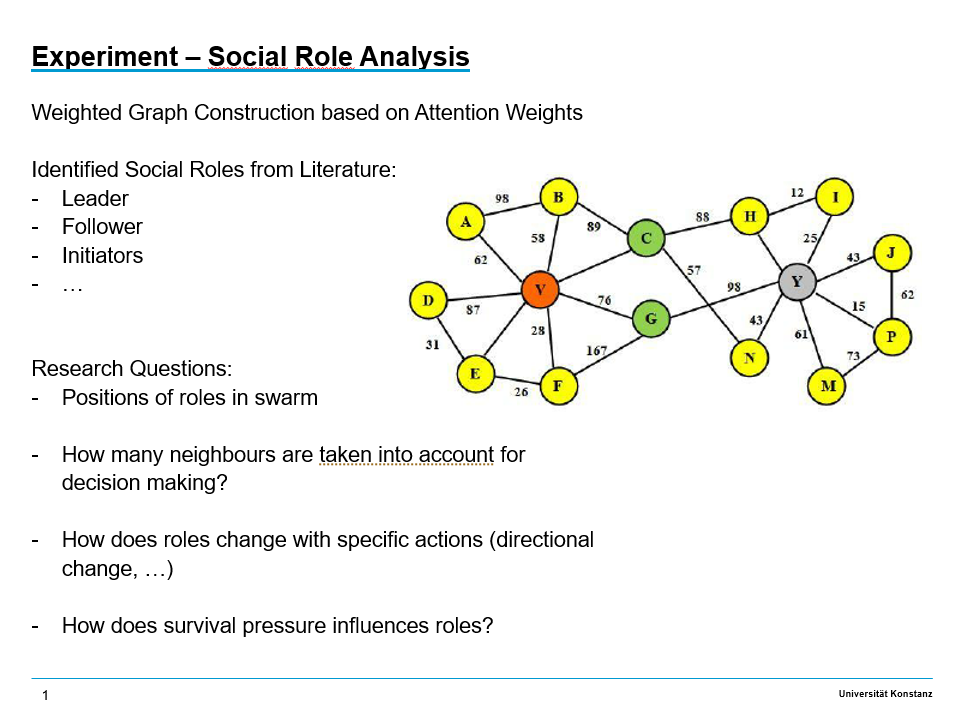

In [1]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import torch
import pickle
import keyboard
from utils.es_utils import *
from utils.env_utils import *
from utils.eval_utils import *
from utils.train_utils import *
from models.Buffer import Buffer, Pool
from models.Discriminator import Discriminator
from models.DeepGenerator import GeneratorPolicy
from marl_aquarium import aquarium_v0

In [2]:
'''
Unterteilung in Leader, Follower, Initiators (und auch Recruiters welche andere animieren)
- Leadership sei teilweise asymmetrisch
- Geschwindigkeits-induzierte Führung (https://doi.org/10.1016/j.cub.2017.08.004)
- Verhaltenskaskaden beim Informationsfluss (https://doi.org/10.1038/s41598-022-14337-0)
'''

'\nUnterteilung in Leader, Follower, Initiators (und auch Recruiters welche andere animieren)\n- Leadership sei teilweise asymmetrisch\n- Geschwindigkeits-induzierte Führung (https://doi.org/10.1016/j.cub.2017.08.004)\n- Verhaltenskaskaden beim Informationsfluss (https://doi.org/10.1038/s41598-022-14337-0)\n'

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
policy_dir = rf'..\models\trained_policies'

pred_policy = torch.load(os.path.join(policy_dir, "gail_pred_policy.pt"), weights_only=False)
prey_policy = torch.load(os.path.join(policy_dir, "gail_prey_policy.pt"), weights_only=False)

In [4]:
# Expert Data
total_detections=33
ftw_path = rf"..\data\processed\pred_prey_interactions\full_track_windows\{total_detections}"

start_frame_pool = Pool(max_length=12100, device=device)
start_frame_pool.generate_startframes(ftw_path)
print(f"Start frames in pool: {len(start_frame_pool)}")

Start frames in pool: 11978


In [5]:
env = parallel_env(predator_count=1, prey_count=32, action_count=360, use_walls=False, render_mode="human")
positions = start_frame_pool.sample(n=1)
env.reset(options=positions)

n_frames = 1000

logs = {"predator": {"frame": [],  "x": [], "y": [], "dx": [], "dy": [], "vx": [], "vy": [], "action": [], "mu": [], "sigma": [], "weights": []},
        "prey": {"frame": [],  "x": [], "y": [], "dx": [], "dy": [], "vx": [], "vy": [], "actions": [], "mu": [], "sigma": [], "weights": []}}

for frame in range(n_frames):
    global_state = env.state().item()
    pred_tensor, prey_tensor, xs, ys, dx, dy, vxs, vys = get_eval_features(global_state)
    current_frame = frame+1

    ##### Predator #####

    pred_states = pred_tensor[..., :4]
    action_pred, mu_pred, sigma_pred, weights_pred = pred_policy.forward_pred(pred_states)
    dis_pred = continuous_to_discrete(action_pred, 360, role='predator')

    logs["predator"]["frame"].append(current_frame)
    logs["predator"]["x"].append(xs[0])
    logs["predator"]["y"].append(ys[0])
    logs["predator"]["dx"].append(dx[0])
    logs["predator"]["dy"].append(dy[0])
    logs["predator"]["vx"].append(vxs)
    logs["predator"]["vy"].append(vys)
    logs["predator"]["action"].append(dis_pred)
    logs["predator"]["mu"].append([mu[0] for mu in mu_pred.detach().numpy()])
    logs["predator"]["sigma"].append([sigma[0] for sigma in sigma_pred.detach().numpy()])
    logs["predator"]["weights"].append(weights_pred.detach().numpy()[0])

    ##### Prey #####
    # HIER WEITERMACHEN - OUTPUT PREY WAR FALSCH
    prey_states = prey_tensor[..., :5]
    action_prey, mu_prey, sigma_prey, weights_prey = prey_policy.forward_prey(prey_states)
    dis_prey = continuous_to_discrete(action_prey, 360, role='prey')

    logs["prey"]["frame"].append(current_frame)
    logs["prey"]["actions"].append(action_prey.detach().numpy())

    for i in range(1, mu_np.shape[0]):
        logs["prey"]["mu"].append(mu_np[i])
        logs["prey"]["sigma"].append(sigma_np[i])
        logs["prey"]["weights"].append(weights_np[i])
        logs["prey"]["x"].append(xs[0])
        logs["prey"]["y"].append(ys[0])
        logs["prey"]["dx"].append(dx[0])
        logs["prey"]["dy"].append(dy[0])
        logs["prey"]["vx"].append(vxs[i])
        logs["prey"]["vy"].append(vys[i])

    action_dict = {'predator_0': dis_pred}
    for i, agent_name in enumerate(sorted([agent for agent in env.agents if agent.startswith("prey")])):
        action_dict[agent_name] = dis_prey[i]

    env.step(action_dict)
    env.render()

try:
    env.close()
except:
    pass

with open(rf'..\data\evaluation\sim_logs_{n_frames}.pkl', 'wb') as f:
    pickle.dump(logs, f)

NameError: name 'mu_np' is not defined

In [145]:
print(prey_states.shape)
print(action_pred)
print(len(mu_pred))
print(len(sigma_pred))
print(len(weights_pred[0]))

torch.Size([32, 32, 5])
tensor([2.0210], grad_fn=<SumBackward1>)
32
32
32


In [ ]:
mu_prey.detach().numpy()

array([-0.3196952], dtype=float32)

In [120]:
df_pred = pd.DataFrame(logs["prey"])
df_pred

ValueError: All arrays must be of the same length

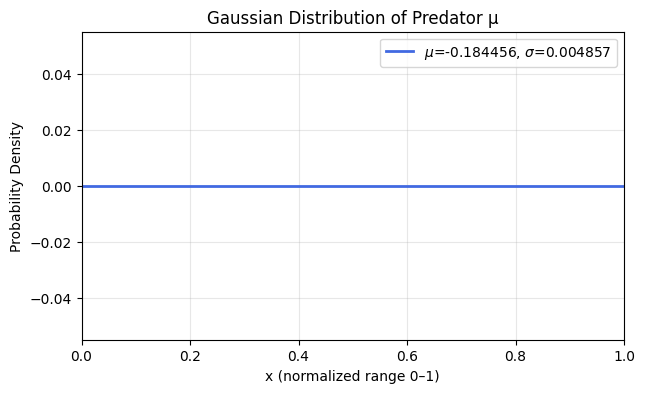

In [63]:
# Plot of average mu and sigma for predator
sigma_pred = logs["predator"]["sigma"][0].mean()
mu_pred = logs["predator"]["mu"][0].mean()

# x-Achse fix von 0 bis 1
x = np.linspace(0, 1, 1000)

# Berechne die Dichtefunktion der Normalverteilung
y = (1 / (sigma_pred * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu_pred) / sigma_pred) ** 2)

# Plot
plt.figure(figsize=(7, 4))
plt.plot(x, y, color="royalblue", linewidth=2, label=f"$\mu$={mu_pred:.6f}, $\sigma$={sigma_pred:.6f}")
plt.title("Gaussian Distribution of Predator μ")
plt.xlabel("x (normalized range 0–1)")
plt.ylabel("Probability Density")
plt.xlim(0, 1)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
'Hier Graph zeichnen mit aktuellen Positions, Bildern und Heading Angle Ausrichtung'

def draw_customized_graph():
    

array([2.4131407e-06, 4.3533731e-12, 3.5219350e-15, 1.6459893e-06,
       9.6391706e-15, 3.7445895e-09, 8.0663383e-01, 7.8788169e-02,
       1.0193185e-12, 5.7379186e-09, 3.1735779e-19, 1.2506565e-20,
       3.9060871e-18, 3.8141581e-05, 7.0420186e-19, 1.7456578e-03,
       1.9062006e-06, 3.5091162e-14, 8.6849630e-18, 1.3943895e-19,
       2.1766766e-05, 2.9480143e-10, 1.1185291e-01, 6.8768338e-07,
       4.3722168e-10, 1.8558952e-10, 3.4513255e-15, 3.5714788e-08,
       6.8087154e-19, 1.4181723e-12, 4.2933891e-13, 9.1279752e-04],
      dtype=float32)